**Parameters chosen to price Asian Barrier Option:**

1.   Maturity (T): 1 year
2.   Spot (S) : 120
3.   Strike (K): 110
4.   Volatility (sigma): 35.0 %
5.   Risk Free Rate (r): 5.0 %
6.   Stock Drift Rate (mu): 10.0 %
7.   Barrier (B): 100 

In [ ]:
import cupy as cp
import numpy as np
import math
import time
import numba as nm
from numba import cuda
from numba import njit
from numba import prange

In [ ]:
cp.cuda.set_allocator(None)

paths = 8192000 # number of simulation paths
steps = 365 # each step represent a day in an year of 365 days
T = 1.0 
K = 110.0 # strike price
B = 100.0 # barrier price
S0 = 120.0 # spot price
sigma = 0.35 # percent volatility
mu = 0.1 # interest rate
r = 0.05 # percent drift

* This Monte Carlo simulation code runs as a single thread using two nested for-loops. Each path is iterated in the outer loop, but the underlying asset price is calculated in the inner loop. Numba (Numba @jit  ) helps to complie this code at accelarated runtime. *

In [ ]:
'''Barrier option pricing using single core CPU'''

@njit(fastmath=True)
def pricing_barrier_optionCPU(d_s, T, K, B, S0, sigma, mu, r, d_normals, steps, paths):
    t1 = mu*T/steps
    t2 = math.exp(-r*T)
    t3 = math.sqrt(T/steps)
    running_average = 0.0
    for i in range(paths):
        curr_spotp = S0
        for n in range(steps):
            curr_spotp += t1 * curr_spotp + sigma*curr_spotp*t3*d_normals[i + n * paths]
            running_average = running_average + 1.0/(n + 1.0) * (curr_spotp - running_average)
            if running_average <= B:
                break

        payoff = running_average - K if running_average>K else 0
        d_s[i] = t2 * payoff


In [ ]:
randoms_gpu = cp.random.normal(0, 1, paths * steps, dtype=cp.float32)
randoms_cpu = np_randoms = cp.asnumpy(randoms_gpu)
output =  np.zeros(paths, dtype=np.float32)
pricing_barrier_optionCPU(output, np.float32(T), np.float32(K), 
                    np.float32(B), np.float32(S0), 
                    np.float32(sigma), np.float32(mu), 
                    np.float32(r), randoms_cpu, steps, paths)
start_time = time.time()
pricing_barrier_optionCPU(output, np.float32(T), np.float32(K), 
                    np.float32(B), np.float32(S0), 
                    np.float32(sigma), np.float32(mu), 
                    np.float32(r), randoms_cpu, steps, steps)
average_stock_price = output.mean()
end_time = time.time()
'predicted average stock price {stockprice} and time elapsed {el_time}'.format(stockprice=average_stock_price,el_time=end_time-start_time)

'predicted average stock price 18.711360931396484 and time elapsed 0.004768848419189453'

* The above code is modified to take advantage of multi code cpus present in multi processor.

**NUMBA GPU**
* Using CUDA support for GPU via Numba.cuda.jit in python.The above code can be parallized to run faster using mutliple threads and blocks,similar to the CPU multiple core code except that we parallelize the outer loop on the GPU. Running this code and calculating amount of time taken to run it.

* Using Shared memory we can optimize the above code to increase the parallel speed up. There are other libraries like CUPY can help to implement effective shared memory versions to increase speed to a greated extent.

In [ ]:
'''Barrier option pricing using multi core CPUs'''

@njit(fastmath=True, parallel=True)
def pricing_barrier_optionCPUmulticore(d_s, T, K, B, S0, sigma, mu, r, d_normals, steps, paths):
    t1 = mu*T/steps
    t2 = math.exp(-r*T)
    t3 = math.sqrt(T/steps)
    for i in prange(paths):
        curr_spotp = S0
        running_average = 0.0
        for n in range(steps):
            curr_spotp += t1 * curr_spotp + sigma*curr_spotp*t3*d_normals[i + n * paths]
            running_average = running_average + 1.0/(n + 1.0) * (curr_spotp - running_average)
            if running_average <= B:
                break
        payoff = running_average - K if running_average>K else 0
        d_s[i] = t2 * payoff

'''Barrier option pricing using CUDA GPU global memory'''

@cuda.jit
def numba_gpu_barrier_optionpricing(d_s, T, K, B, S0, sigma, mu, r, d_normals, steps, paths):
    # ii - overall thread index
    ii = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    stride = cuda.gridDim.x * cuda.blockDim.x
    t1 = mu*T/steps
    t2 = math.exp(-r*T)
    t3 = math.sqrt(T/steps)
    running_average = 0.0
    for i in range(ii, paths, stride):
        curr_spotp = S0
        for n in range(steps):
            curr_spotp += t1 * curr_spotp + sigma*curr_spotp*t3*d_normals[i + n * paths]
            running_average += (curr_spotp - running_average) / (n + 1.0)
            if running_average <= B:
                break
        payoff = running_average - K if running_average>K else 0
        d_s[i] = t2 * payoff

'''Barrier option pricing using CUDA GPU shared memory'''

@cuda.jit
def numba_gpu_barrier_optionpricing_shared_mem(d_s, T, K, B, S0, sigma, mu, r, d_normals, steps, paths):
    shared = cuda.shared.array(shape=0, dtype=nm.float32)
    # load to shared memory
    path_offset = cuda.blockIdx.x * cuda.blockDim.x
    ii = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    stride = cuda.gridDim.x * cuda.blockDim.x
    t1 = mu*T/steps
    t2 = math.exp(-r*T)
    t3 = math.sqrt(T/steps)
    running_average = 0.0
    for i in range(ii, paths, stride):
        curr_spotp = S0
        for n in range(steps):
            shared[cuda.threadIdx.x] = d_normals[path_offset + cuda.threadIdx.x + n * paths]
            curr_spotp += t1 * curr_spotp + sigma*curr_spotp*t3*shared[cuda.threadIdx.x]
            running_average += (curr_spotp - running_average) / (n + 1.0)
            if running_average <= B:
                break
        payoff = running_average - K if running_average>K else 0
        d_s[i] = t2 * payoff





In [ ]:
'''Option Price calcluation using multi core cpus'''
pricing_barrier_optionCPUmulticore(output, np.float32(T), np.float32(K), 
                    np.float32(B), np.float32(S0), 
                    np.float32(sigma), np.float32(mu), 
                    np.float32(r), randoms_cpu, steps, paths)
start_time = time.time()
pricing_barrier_optionCPUmulticore(output, np.float32(T), np.float32(K), 
                    np.float32(B), np.float32(S0), 
                    np.float32(sigma), np.float32(mu), 
                    np.float32(r), randoms_cpu, steps, paths)
average_stock_price = output.mean()
end_time = time.time()
'predicted average stock price {stockprice} and time elapsed {el_time}'.format(stockprice=average_stock_price,el_time=end_time-start_time)


'predicted average stock price 18.71137809753418 and time elapsed 2.8271894454956055'

In [ ]:
'''Option Price calcluation using CUDA gpu global memory'''
number_of_threads = 256
number_of_blocks = (paths-1) // number_of_threads + 1
output = cp.zeros(paths, dtype=cp.float32)
numba_gpu_barrier_optionpricing[(number_of_blocks,), (number_of_threads,)](output, np.float32(T), np.float32(K), 
                    np.float32(B), np.float32(S0), 
                    np.float32(sigma), np.float32(mu), 
                    np.float32(r), randoms_gpu, steps, paths)
start_time = time.time()
numba_gpu_barrier_optionpricing[(number_of_blocks,), (number_of_threads,)](output, np.float32(T), np.float32(K), 
                    np.float32(B), np.float32(S0), 
                    np.float32(sigma), np.float32(mu), 
                    np.float32(r), randoms_gpu, steps, paths)
average_stock_price = output.mean()
cuda.synchronize()
end_time = time.time()
'predicted average stock price {stockprice} and time elapsed {el_time}'.format(stockprice=average_stock_price,el_time=end_time-start_time)


'predicted average stock price 18.71137046813965 and time elapsed 0.23681950569152832'

In [ ]:
'''Option Price calcluation using CUDA gpu shared memory'''

number_of_threads = 256
number_of_blocks = (paths-1) // number_of_threads + 1
output1 = cp.zeros(steps, dtype=cp.float32)
shared_buffer_size = number_of_threads * 4
numba_gpu_barrier_optionpricing_shared_mem[(number_of_blocks,), (number_of_threads,), 0, shared_buffer_size](output1, np.float32(T), np.float32(K), 
                    np.float32(B), np.float32(S0), 
                    np.float32(sigma), np.float32(mu), 
                    np.float32(r), randoms_gpu, steps, paths)
start_time = time.time()
numba_gpu_barrier_optionpricing_shared_mem[(number_of_blocks,), (number_of_threads,), 0, shared_buffer_size](output1, np.float32(T), np.float32(K), 
                    np.float32(B), np.float32(S0), 
                    np.float32(sigma), np.float32(mu), 
                    np.float32(r), randoms_gpu, steps, paths)
average_stock_price = output1.mean()
cuda.synchronize()
end_time = time.time()
'predicted average stock price {stockprice} and time elapsed {el_time}'.format(stockprice=average_stock_price,el_time=end_time-start_time)

'predicted average stock price 18.71137046813965 and time elapsed 0.12233495712280273'

In [ ]:
del randoms_gpu 
del randoms_cpu
del output


In [ ]:
import torch
from torch.utils.dlpack import from_dlpack

**Using Deep Learning to price the asian Barrier Option and tarining the model using batch set of predicted option prices and paths.**

* Monte Carlo simulation was run on the Asian Barrier option using Numba. 
* A Monte Carlo simulation needs millions of paths to get an accurate answer which is computationally intensive.
* In addition to being extremely accurate and fast, the deep learning model can produce valuations a million times faster than traditional models. 
* In the this notebook, we will use a fully connected network to learn the pricing mode of the Asian Barrier option. 
* Monte Carlo simulation is used as pricing ground truth for the training. 

In [ ]:
''' Implementing Neural Network training model by generating batch of monte carlo simulations '''

%%writefile numba_dataset.py 
import cupy as cp
import numpy as np
import math
import time
import numba as nm
from numba import cuda
import torch
from torch.utils.dlpack import from_dlpack
cp.cuda.set_allocator(None)
@cuda.jit
def gpu_batch_barrier_optionpricing(d_s, T, K, B, S0, sigma, mu, r, d_normals, steps, paths, batch):
    # ii - overall thread index
    ii = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    stride = cuda.gridDim.x * cuda.blockDim.x
    t3 = math.sqrt(T/steps)
    for i in range(ii, paths * batch, stride):
        batch_id = i // paths
        path_id = i % paths
        t1 = mu[batch_id]*T/steps
        t2 = math.exp(-r[batch_id]*T)
        running_average = 0.0
        s_curr = S0[batch_id]
        for n in range(steps):

            curr_spotp += t1 * curr_spotp + sigma[batch_id]*curr_spotp*t3*d_normals[path_id + batch_id * paths + n * paths * batch]
            running_average = running_average + 1.0/(n + 1.0) * (curr_spotp - running_average)
            if i==0 and batch_id == 2:
                print(curr_spotp)
            if running_average <= B[batch_id]:
                break
        payoff = running_average - K[batch_id] if running_average > K[batch_id] else 0
        d_s[i] = t2 * payoff

class NumbaOptionDataSet(object):
    
    def __init__(self, max_len=10, number_path = 1000, batch=2, threads=512, seed=15):
        self.num = 0
        self.max_length = max_len
        self.paths = number_path
        self.steps = 365
        self.batch = batch
        self.T = np.float32(1.0)
        self.output = cp.zeros(self.batch*self.paths, dtype=cp.float32) 
        self.number_of_blocks = (self.batch * self.batch - 1) // threads + 1
        self.number_of_threads = threads
        cp.random.seed(seed)
        
    def __len__(self):
        return self.max_length
        
    def __iter__(self):
        self.num = 0
        return self
    
    def __next__(self):
        if self.num > self.max_length:
            raise StopIteration
        X = cp.random.rand(self.batch, 6, dtype=cp.float32)
        # scale the [0, 1) random numbers to the correct range for each of the option parameters
        X = X * cp.array([200.0, 0.99, 200.0, 0.4, 0.2, 0.2], dtype=cp.float32)
        # make sure the Barrier is smaller than the Strike price
        X[:, 1] = X[:, 0] * X[:, 1]
        randoms = cp.random.normal(0, 1, self.N_BATCH * self.N_PATHS * self.N_STEPS, dtype=cp.float32)
        gpu_batch_barrier_optionpricing[(self.number_of_blocks,), (self.number_of_threads,)](self.output, self.T, X[:, 0], 
                              X[:, 1], X[:, 2], X[:, 3], X[:, 4], X[:, 5], randoms, self.steps, self.paths, self.batch)
        o = self.output.reshape(self.batch, self.paths)
        Y = o.mean(axis = 1) 
        self.num += 1
        return (from_dlpack(X.toDlpack()), from_dlpack(Y.toDlpack()))
# ds = NumbaOptionDataSet(10, number_path=100000, batch=16, seed=15)
# for i in ds:
#     print(i[1])

In [ ]:
%%writefile model.py
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.dlpack import from_dlpack

class Net(nn.Module):

    def __init__(self, hidden=1024):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(6, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, hidden)
        self.fc4 = nn.Linear(hidden, hidden)
        self.fc5 = nn.Linear(hidden, hidden)
        self.fc6 = nn.Linear(hidden, 1)
        self.register_buffer('norm',
                             torch.tensor([200.0,
                                           198.0,
                                           200.0,
                                           0.4,
                                           0.2,
                                           0.2]))

    def forward(self, x):
        # normalize the parameter to range [0-1] 
        x = x / self.norm
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        x = F.elu(self.fc5(x))
        return self.fc6(x)

Overwriting model.py


In [ ]:
from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
from numba_dataset import NumbaOptionDataSet
timer = Timer(average=True)
model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
dataset = NumbaOptionDataSet(max_len=10000, number_path = 1024, batch=4800)
loss_arr=[]
time_arr=[]
predticted_prices=[]
def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    y_pred = model(x)
    predticted_prices.append(y_pred)
    loss = loss_fn(y_pred[:,0], y)
    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 10

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        loss_arr.append(engine.state.output)
        time_arr.append(timer.value())
        print('loss', engine.state.output, 'average time', timer.value())
        
trainer.run(dataset, max_epochs=10)

**Output**

loss 2917.700439453125 average time 0.04273516898974776

loss 1929.130615234375 average time 0.03415941642597318

loss 1821.3369140625 average time 0.031302196563531955

loss 1664.59423828125 average time 0.029884519218467177

loss 815.2304077148438 average time 0.029020193852484225

loss 209.09133911132812 average time 0.02845463378665348

loss 54.87837219238281 average time 0.028038838186434337

loss 32.24896240234375 average time 0.027731372462585568

* One of the benefits of building a deep learning model is that the required parameters can be easily computed and the relation can be found between various parameters by plotitng them. 

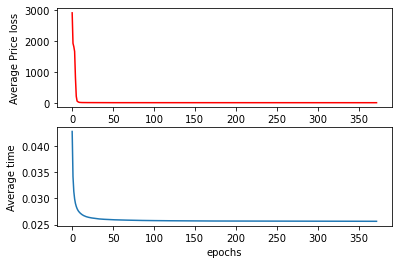

In [ ]:
'''Average Price loss for Each iteration and Reduced amount of time to train the model '''
import matplotlib.pyplot as plt
plt.figure(1)
plt.subplot(211)
plt.plot(loss_arr,'r')
plt.ylabel('Average Price loss')
plt.xlabel('epochs')
plt.subplot(212)
plt.plot(time_arr)
plt.ylabel('Average time')
plt.xlabel('epochs')
plt.show()

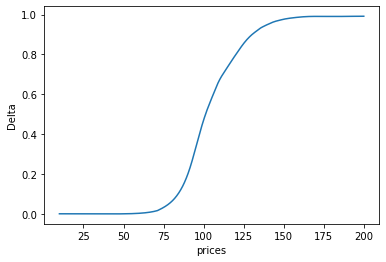

In [ ]:
''' Plotting option price with respect to change in Strike Price '''
import pylab
import numpy as np
import torch
def compute_delta(S):
    inputs = torch.tensor([[110.0, 100.0, S, 0.35, 0.1, 0.05]]).cuda()
    inputs.requires_grad = True
    x = model(inputs.float())
    x.backward()
    first_order_gradient = inputs.grad
    return first_order_gradient[0][2]
prices = np.arange(10, 200, 0.1)
deltas = []
for p in prices:
    deltas.append(compute_delta(p).item())
fig = pylab.plot(prices, deltas)
pylab.xlabel('prices')
pylab.ylabel('Delta')
fig

* Volatility implied in an option based on its quoted price tells you the expected volatility of the underlying asset. This is the reverse mapping of price to the option parameter based on the model, a difficult task with Monte Carlo simulation. However, it is an easy task if we have a deep learning pricing model. For instance, plotting the volatility-option price relationship is straightforward

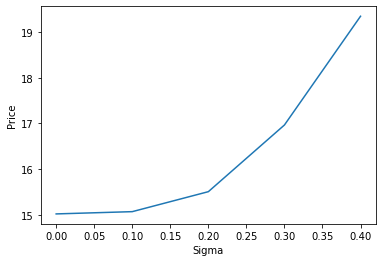

In [ ]:
'''  Plotting Volatality affect on option prices'''
def compute_price(sigma):
    inputs = torch.tensor([[110.0, 100.0, 120.0, sigma, 0.1, 0.05]]).cuda()
    x = model(inputs.float())
    return x.item()
sigmas = np.arange(0, 0.5, 0.1)
prices = []
for s in sigmas:
    prices.append(compute_price(s))
fig3 = pylab.plot(sigmas, prices)
pylab.xlabel('Sigma')
pylab.ylabel('Price')
fig3